## Project: Generative Adversarial Networks for Wiki Art Portrait Dataset
## Name:YANG Haobo    Sid:20656441

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Create image dataset and dataloader

In [2]:
dataset = dset.ImageFolder(root='./dataset',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True)


## Architecture guidelines for stable Deep Convolutional GANs from original paper:
1. Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
2. Use batchnorm in both the generator and the discriminator.
3. Remove fully connected hidden layers for deeper architectures.
4. Use ReLU activation in generator for all layers except for the output, which uses Tanh.
5. Use LeakyReLU activation in the discriminator for all layers.

## Define initial weight as guided in paper:
Apply the weights_init function to randomly initialize convolutional weights to mean=0, stdev=0.02, batch normalization weights to mean=1 , stdev=0.02

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator and Discriminator:
Generator maps the latent variables to images. It consists of 2d convolution transpose layers, 2d batch norm layers and relu functions. The output activation function is Tanh as specified in the paper. The batch norm functions help the flow of gradients a lot.

Discriminator takes images as inputs and outputs a probability that the images are real or fake. The activation functions are LeakyReLU and end with a sigmoid funtion since the ouput should range in (0,1).

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n=64
Generator = nn.Sequential(
            nn.ConvTranspose2d(100, n * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(n * 8, n * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( n * 4, n * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( n * 2, n, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n),
            nn.ReLU(True),
            nn.ConvTranspose2d( n, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(device)

Discriminator = nn.Sequential(
            nn.Conv2d(3, n, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n, n * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n * 2, n * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n * 4, n * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)

Generator.apply(weights_init)
Discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

## Network structures

In [10]:
print(Generator)
print(Discriminator)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), 

## Loss and optimizer:
Use binary cross entropy loss as loss function, and use Adam optimizer with r=0.0002 and beta1=0.5 as specified in DCGAN paper.

In [11]:
criterion = nn.BCELoss()
real_label = 1
fake_label = 0

optimizerG = optim.Adam(Generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(Discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Fixed latent variables to show the training iterations performance

In [12]:
fixed_noise = torch.randn(16, 100, 1, 1, device=device)

## Training:
Following Algorithem 1 from DCGAN paper, train the discriminator and then train the generator.

In [13]:
img_list = []
G_losses = []
D_losses = []
fake_list = []
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        Discriminator.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label,device=device)
        output = Discriminator(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = Generator(noise)
        label.fill_(fake_label)
        output = Discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        Generator.zero_grad()
        label.fill_(real_label)
        output = Discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        G_losses.append(errG.item())
        D_losses.append(errD.item())


    with torch.no_grad():
        fake = Generator(fixed_noise).detach()
    fake_list.append(fake)
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    print(epoch,end='\r')

## Loss changes with epoches
Over-fitting can be observed with more interations.  

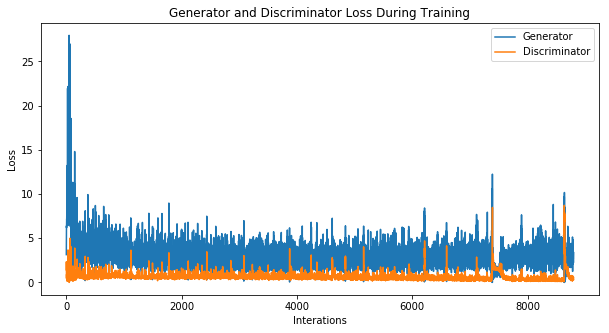

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Interations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Images generated using fixed noise in training process
Due to the limited number of training images, the model is over fitted when some of the fake images seem to be incomplete. The performance should be better with more training images and larger resolutions.

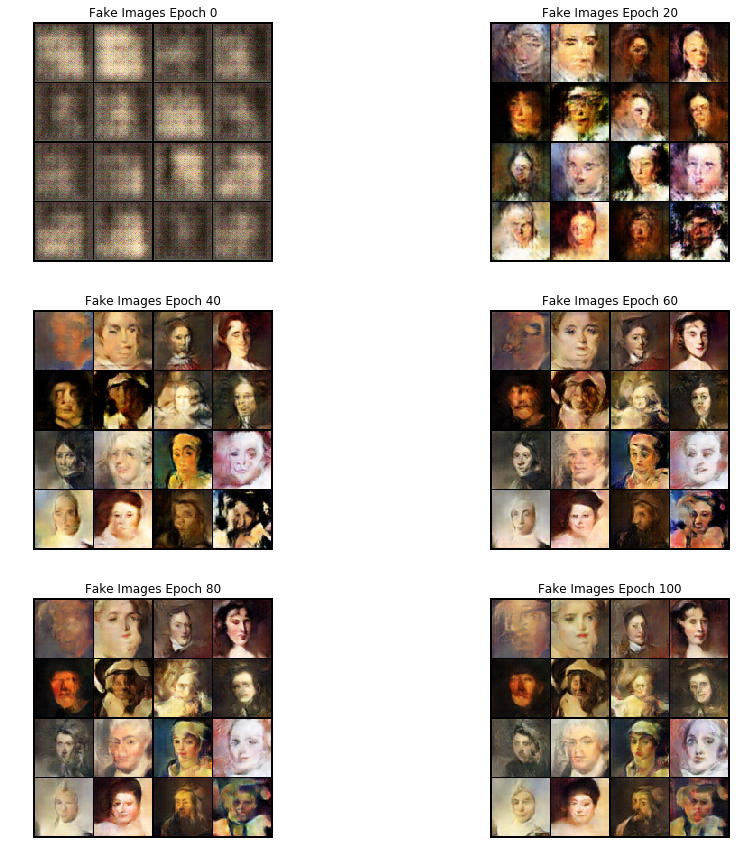

In [19]:
img_l=[]
for i in fake_list:
    img_l.append(vutils.make_grid(i, nrow=4,padding=2, normalize=True))
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.axis("off")
plt.title("Fake Images Epoch 0")
plt.imshow(np.transpose(img_l[0].cpu(),(1,2,0)))

plt.subplot(3,2,2)
plt.axis("off")
plt.title("Fake Images Epoch 20")
plt.imshow(np.transpose(img_l[19].cpu(),(1,2,0)))

plt.subplot(3,2,3)
plt.axis("off")
plt.title("Fake Images Epoch 40")
plt.imshow(np.transpose(img_l[39].cpu(),(1,2,0)))


plt.subplot(3,2,4)
plt.axis("off")
plt.title("Fake Images Epoch 60")
plt.imshow(np.transpose(img_l[59].cpu(),(1,2,0)))

plt.subplot(3,2,5)
plt.axis("off")
plt.title("Fake Images Epoch 80")
plt.imshow(np.transpose(img_l[79].cpu(),(1,2,0)))

plt.subplot(3,2,6)
plt.axis("off")
plt.title("Fake Images Epoch 100")
plt.imshow(np.transpose(img_l[99].cpu(),(1,2,0)))
plt.show()

## Single fake image with training process

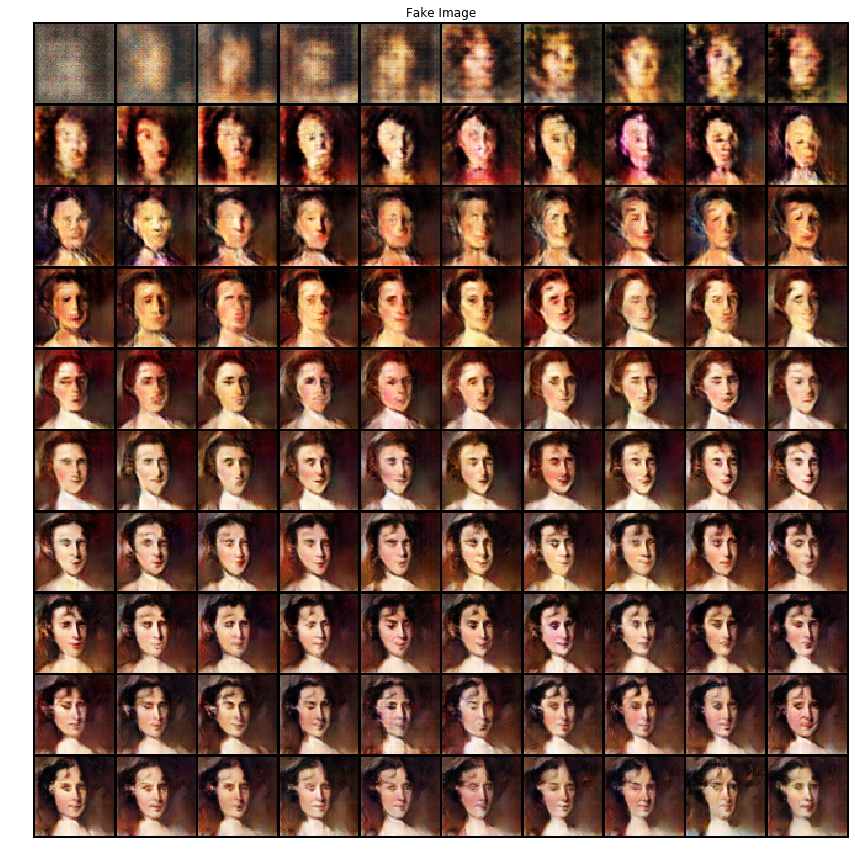

In [21]:
img_1=[]
for i in fake_list:
    img_1.append(i[3])

plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Image")
plt.imshow(np.transpose(vutils.make_grid(img_1, nrow=10,padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Fake images with fixed noise but set first 20 latent variables to 0
Different latent variables can produce different images. By setting first 20 latent variables to 0, the generator can produce similar but different images. As we can see, the first 20 latent variables mainly change the shape of the faces and the colors.

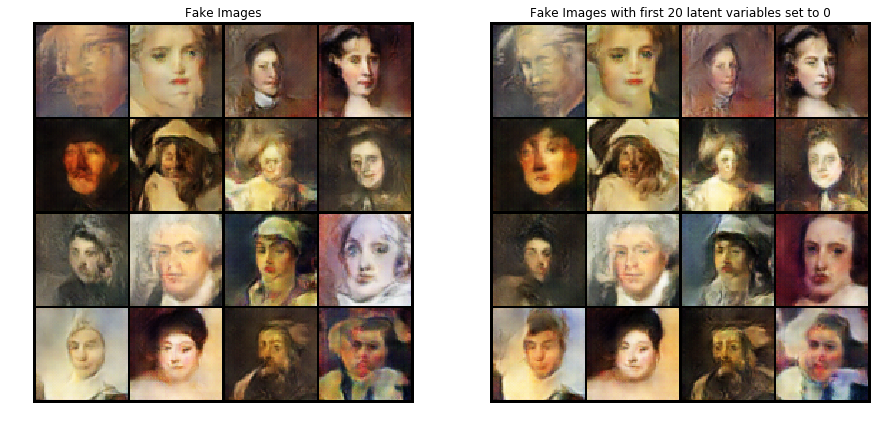

In [35]:
fixed_noise2=fixed_noise.clone()
for i in fixed_noise2:
    i[0:20]=0
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_l[99].cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images with first 20 latent variables set to 0")
plt.imshow(np.transpose(vutils.make_grid(Generator(fixed_noise2).detach().cpu(),nrow=4, padding=2, normalize=True),(1,2,0)))
plt.show()

## Unstable gradient of the discriminator
In different experiments with higher rosultions and more fetures, the gradients become very unstable. Many model that expected to have better results cannot be trained and wasted many time. It is very necessary to check the losses during the training in order to avoid unsuccessful training.